# Data Science for Executives 

## Churn case study

<br></br>
<center>
<img src="./images/galvanize-logo.png" alt="galvanize logo" align="center" style="width: 200px;"/>
</center>

In [35]:
import os
import sys
import time
import re
import itertools
from string import punctuation, printable
import numpy as np
import pandas as pd
import spacy
import joblib
from collections import Counter
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import seaborn as sns

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en')

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## supress all warnings (not to be used during development)
import warnings
warnings.filterwarnings("ignore")

Notes

## What are we going to learn?

* A generalizable process to *investigate* the performance of a model
* A generalizable way to *investigate* the relationship between business metrics and evaluation metrics 


## Follow through

> The basic idea of the follow-through is to tune, train and deploy your model, then once you have collected some performance data return to the familiar world of data visualization and hypothesis testing to investigate the relationship between model performance (evaluation metrics) and business metrics.

<br></br>
<br></br>
<center>
<img src="./images/business-discussion.jpg" alt="discussion" align="center" style="width: 300px;"/>
</center>

notes

### Data Science Workflow

<br></br>
<center>
<img src="./images/project-workflow-simple.png" alt="workflow simple" align="center" style="width: 500px;"/>
</center>

notes

## Synopsis


AAVAIL has recently enabled comments on its streaming service.  Feedback from users has indicated that toxic comments and trolls have caused some users to chrun.  Comments need to be monitored for automatic removal of inappropriate content.  

## Outline

1. Optimize a text classification Pipeline to be deployed for use
2. Iterate on and tune the model pipeline
3. Use visualization techniques to relate the evaluation metrics to the business metrics

notes

## Load Data

In [36]:
data_dir = os.path.join(".","data")
movie_reviews = load_files(os.path.join(data_dir,"movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names

In [37]:
def plot_corpus_summary(corpus):
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    tokens_per_doc = [len(str(doc).split(" ")) for doc in corpus]
    all_docs = [str(doc).split(" ") for doc in corpus]
    all_docs = list(itertools.chain.from_iterable(all_docs))
    unique_tokens, token_counts = np.unique(all_docs, return_counts=True)
    
    print("---------------------------")
    print("num docs", len(corpus))
    print("median tokens",np.median(tokens_per_doc))
    print("num tokens",len(all_docs))
    print("unique tokens", unique_tokens.size)
    print("---------------------------")
  
    sns.distplot(tokens_per_doc, ax=ax1)
    sns.distplot(token_counts, ax=ax2)
    ax1.set_title("Document Sizes")
    ax2.set_title("Token Counts") 
    


notes

## Documents Summary

---------------------------
num docs 2000
median tokens 698.0
num tokens 1496584
unique tokens 57588
---------------------------


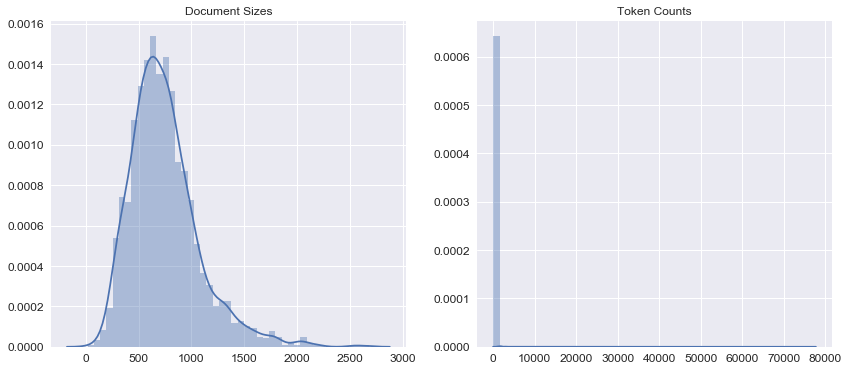

In [52]:
plot_corpus_summary(X)

notes

In [39]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub("\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)   
    
## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
#print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
#print("\n"+processed[0])

## Process the data and use staging

In [40]:
saved_corpus = 'processed-corpus.npz'
if not os.path.exists(saved_corpus):
    time_start = time.time()
    processed_corpus = [lemmatize_document(doc, STOPLIST) for doc in X]
    args = {'corpus':processed_corpus}
    np.savez_compressed(saved_corpus,**args)
    print("process time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
else:
    print("loading {} from file".format(saved_corpus))
    npz = np.load(saved_corpus)
    processed_corpus = npz['corpus']

loading processed-corpus.npz from file


---------------------------
num docs 2000
median tokens 336.0
num tokens 716351
unique tokens 44193
---------------------------


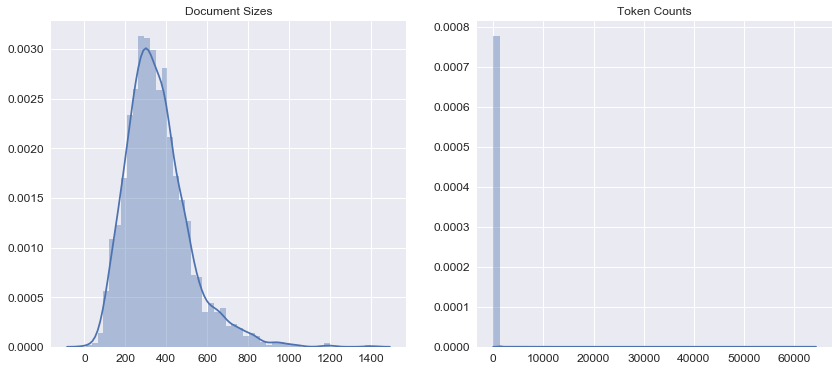

In [41]:
plot_corpus_summary(processed_corpus)

In [42]:
## Ensuring our model generalizes to unseen data

In [43]:
## train-test split

rs = 42
X_train, X_test, y_train, y_test = train_test_split(processed_corpus, y, test_size=0.25, stratify=y, random_state=rs)
print("---------------------------")
print("train", sorted(Counter(y_train).items()))
print("test", sorted(Counter(y_test).items()))
print("targets", target_names)
print("---------------------------")

---------------------------
train [(0, 750), (1, 750)]
test [(0, 250), (1, 250)]
targets ['neg', 'pos']
---------------------------


notes

### Train a baseline model

In [44]:
from sklearn.naive_bayes import ComplementNB

def train_baseline_model():
    time_start = time.time()
    pipe1  = Pipeline(steps=[('tfidf',TfidfVectorizer()),
                             ('nb', ComplementNB())])

    param_grid1 = {
        'tfidf__max_df':[0.4,0.6,0.8],
        'tfidf__max_features': [2000,4000,6000],
        'nb__alpha':[0.01, 0.1, 1.0]   
    }

    grid1 = GridSearchCV(pipe1, param_grid=param_grid1, cv=5, iid=False, n_jobs=-1)
    grid1.fit(X_train, y_train)
    y_pred = grid1.predict(X_test)
    print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
    print(classification_report(y_test, y_pred, target_names=target_names))

In [45]:
train_baseline_model()

train time 00:00:19
              precision    recall  f1-score   support

         neg       0.79      0.82      0.81       250
         pos       0.82      0.78      0.80       250

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



notes

## Train a more complicated model

In [46]:
from sklearn.linear_model import SGDClassifier


def train_better_model():
    time_start = time.time()
    pipe2  = Pipeline(steps=[('tfidf',TfidfVectorizer()),
                             ('sgd', SGDClassifier())])

    param_grid2 = {
        'tfidf__max_df':[0.4,0.6,0.8],
        'tfidf__max_features': [2000,4000,6000],
        'sgd__penalty':['l2', 'l1', 'elasticnet']
    }

    grid2 = GridSearchCV(pipe2, param_grid=param_grid2, cv=5, iid=False, n_jobs=-1)
    grid2.fit(X_train, y_train)
    y_pred = grid2.predict(X_test)
    print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
    print(classification_report(y_test, y_pred, target_names=target_names))

In [47]:
train_better_model()

train time 00:00:19
              precision    recall  f1-score   support

         neg       0.83      0.79      0.81       250
         pos       0.80      0.84      0.82       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



In [48]:
def simulate_production(test_accuracy, num_weeks=26):
    """
    INPUT: takes a value for test model accuracy
    OUTPUT: returns a data frame with relevant
    """
    
    if test_accuracy < 0 or test_accuracy > 1.0:
        raise Exception("test accuracy must be between 0 and 1")
    
    ## simulate test accuracy (two component gaussian)
    modes = np.random.binomial(n=1,p=0.3,size=num_weeks)
    mode1 = np.where(modes==0)[0]
    mode2 = np.where(modes==1)[0]
    projected_em = np.zeros(num_weeks)
    projected_em[mode1] = stats.norm(loc=test_accuracy,scale=0.02).rvs(mode1.size)
    projected_em[mode2] = stats.norm(loc=test_accuracy,scale=0.04).rvs(mode2.size)
    projected_em[projected_em > 0.99] = 0.99
    
    #print(projected_em)
    min_val = 0.5
    projected_bm = (1.0 - ((projected_em - min_val) / (1.0 - min_val))) * .1
    #print(projected_bm)
    
    website_effects = np.array([0.0,0.02,-0.02])
    website = np.sort(np.random.randint(0,3,num_weeks))
    
    for sv in np.unique(website):
        projected_bm[website==sv] = projected_bm[website==sv] + website_effects[sv]
    
    data = {'churn_rate':projected_bm,
            'accuracy':projected_em,
            'website':website}
    
    return(pd.DataFrame(data))

In [49]:

def run_simulation():
    report = classification_report(y_test, y_pred, target_names=target_names,output_dict=True)
    df = simulate_production(report['accuracy'])

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(111)

    n_weeks = df.shape[0]

    color = 'tab:red'
    ax1.set_xlabel('week')
    ax1.set_ylabel('churn_rate', color=color)
    p1 = ax1.plot(np.arange(n_weeks), df['churn_rate'], color=color, lw=4)
    ax1.tick_params(axis='y',labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    p2 = ax2.plot(np.arange(n_weeks), df['accuracy'], color=color, lw=4)
    ax2.tick_params(axis='y',labelcolor=color)
    ax2.set_ylim((0.6,1.0))

    ax2.legend([p1[0],p2[0]],["churn","accuracy"])

    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="b", lw=2)

    last = -1
    for i,v in enumerate(df['website'].values):
        if v != last:
            ax2.text(i, 0.6, "V {}".format(v), ha="center", va="center", 
                     size=15,rotation=90,
                     bbox=bbox_props)
            ax2.vlines(i,0.6,1.0,linestyles='--')
        last=v
    return(df)

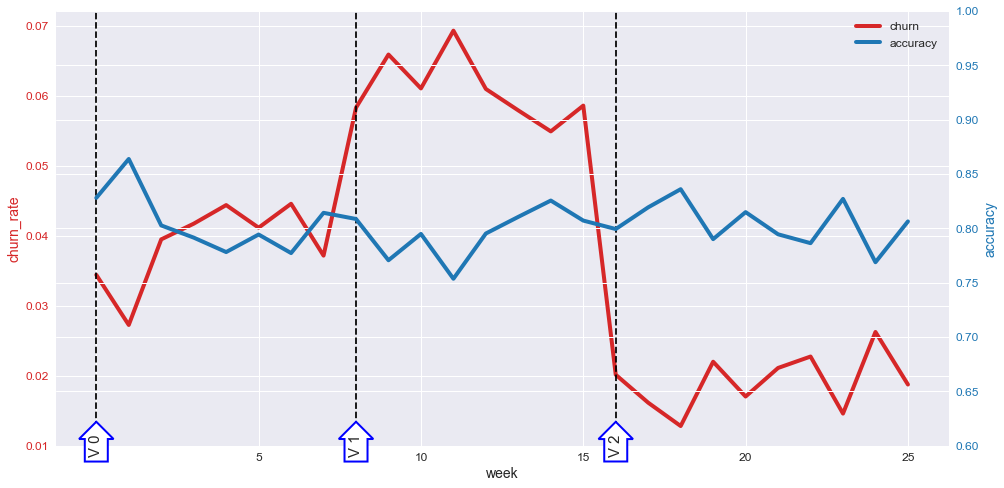

In [50]:
df = run_simulation()

In [51]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='churn_rate ~ accuracy + C(website)', data=df)
res = mod.fit()
print(res.summary()) 

                            OLS Regression Results                            
Dep. Variable:             churn_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.706e+30
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:17:45   Log-Likelihood:                 966.45
No. Observations:                  26   AIC:                            -1925.
Df Residuals:                      22   BIC:                            -1920.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2000   1.32e-16   1.